In [161]:
import sys
sys.path.append("../utils")
from utils import load_data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Import Keras for implementing autoencoders
import keras
from keras.models import Sequential
from keras.layers import Input, Dense
from pathlib import Path
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [162]:
train_data, test_data, train_target = load_data(raw = False, categorical=False)

In [163]:
nb_cell_lines = train_data.shape[0]
print("Number of cell lines: ", nb_cell_lines)

Number of cell lines:  742


In [164]:
# Split the data 
X_train, X_test, y_train, y_test = train_test_split(train_data, train_target, test_size=0.2, random_state=42)

In [26]:
# Define the autoencoder architecture
input_dim = X_train.shape[1]
encoding_dim = 50

# Set the encoding dimension
input_layer = keras.layers.Input(shape=(input_dim,))
encoder = keras.layers.Dense(encoding_dim, activation="relu")(input_layer)
decoder = keras.layers.Dense(input_dim, activation="sigmoid")(encoder)
autoencoder = keras.Model(inputs=input_layer, outputs=decoder)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Summary of the autoencoder architecture
autoencoder.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 19907)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │       995,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 19907)          │     1,015,257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,010,657 (7.67 MB)

 Trainable params: 2,010,657 (7.67 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1134 - val_loss: 0.0183
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0176 - val_loss: 0.0152
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0153 - val_loss: 0.0137
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0134 - val_loss: 0.0128
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0127 - val_loss: 0.0121
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0120 - val_loss: 0.0116
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0116 - val_loss: 0.0110
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0108 - val_loss: 0.0105
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0104 - val_loss: 0.0101
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Encoded Features Shape (Train): (593, 50)
Encoded Features Shape (Test): (149, 50)


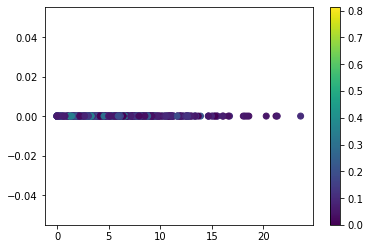

In [28]:
# Use encoder part of the autoencoder for feature selection
encoder = keras.Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)
encoded_features_train = encoder.predict(X_train)
encoded_features_test = encoder.predict(X_test)

# Display the shape of extracted features
print("Encoded Features Shape (Train):", encoded_features_train.shape)
print("Encoded Features Shape (Test):", encoded_features_test.shape)
# plot all encoded features
plt.scatter(encoded_features_train[:,0], encoded_features_train[:,1], c = y_train['AAC'], cmap='viridis')
plt.colorbar()
plt.show()

In [29]:
# --- Encoded Features ---
# Fit a linear regression model using the encoded features
encoded_model = LinearRegression()
encoded_model.fit(encoded_features_train, y_train)

# Make predictions on the test set
y_pred_encoded = encoded_model.predict(encoded_features_test)

# Calculate regression metrics
mse_encoded = mean_squared_error(y_test, y_pred_encoded)
r2_encoded = r2_score(y_test, y_pred_encoded)

# Calculate Spearman's rank correlation for encoded features
spearman_encoded, p_value_encoded = spearmanr(y_test, y_pred_encoded)

print("--- Encoded Features ---")
print("Mean Squared Error (MSE):", mse_encoded)
print("R-squared (R²):", r2_encoded)
print("Spearman's Correlation (ρ):", spearman_encoded)
print("P-value (Spearman):", p_value_encoded)

# --- Non Encoded Features ---
# Fit a linear regression model using the non-encoded features
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate Spearman's rank correlation for non-encoded features
spearman_non_encoded, p_value_non_encoded = spearmanr(y_test, y_pred)

print("--- Non Encoded Features ---")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)
print("Spearman's Correlation (ρ):", spearman_non_encoded)
print("P-value (Spearman):", p_value_non_encoded)


--- Encoded Features ---
Mean Squared Error (MSE): 0.0058525498852071145
R-squared (R²): 0.2182089858675691
Spearman's Correlation (ρ): 0.42218068400224507
P-value (Spearman): 8.192097063648034e-08
--- Non Encoded Features ---
Mean Squared Error (MSE): 0.0068259369138020136
R-squared (R²): 0.08818271575374692
Spearman's Correlation (ρ): 0.39419045364650135
P-value (Spearman): 6.55531476241527e-07


In [ ]:
# Encode the entire data set and save the encoded features
# Add the project root directory to the Python path
project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))
# Load the data
data_path = project_root / 'data' / 'encoded'
total_data = pd.concat([train_data, test_data])
encoded_features = encoder.predict(total_data)
print(encoded_features.shape)
encoded_features = pd.DataFrame(encoded_features, columns=["encoded_feature_" + str(i) for i in range(encoded_features.shape[1])])
encoded_features.to_csv(data_path / 'ae_data.csv', index=False)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(1046, 50)


# VAE

In [202]:
from src.utils.vae import VAE, train, plot_latent_space
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Training Trial 1/20
Epoch 1/20, Train Loss: 2.2733, Val Loss: 0.3634
Epoch 2/20, Train Loss: 0.1829, Val Loss: 0.0946
Epoch 3/20, Train Loss: 0.0720, Val Loss: 0.0513
Epoch 4/20, Train Loss: 0.0457, Val Loss: 0.0398
Epoch 5/20, Train Loss: 0.0363, Val Loss: 0.0340
Epoch 6/20, Train Loss: 0.0313, Val Loss: 0.0307
Epoch 7/20, Train Loss: 0.0281, Val Loss: 0.0278
Epoch 8/20, Train Loss: 0.0258, Val Loss: 0.0257
Epoch 9/20, Train Loss: 0.0239, Val Loss: 0.0240
Epoch 10/20, Train Loss: 0.0223, Val Loss: 0.0226
Epoch 11/20, Train Loss: 0.0210, Val Loss: 0.0216
Epoch 12/20, Train Loss: 0.0201, Val Loss: 0.0206
Epoch 13/20, Train Loss: 0.0193, Val Loss: 0.0199
Epoch 14/20, Train Loss: 0.0185, Val Loss: 0.0193
Epoch 15/20, Train Loss: 0.0180, Val Loss: 0.0189
Epoch 16/20, Train Loss: 0.0174, Val Loss: 0.0181
Epoch 17/20, Train Loss: 0.0171, Val Loss: 0.0177
Epoch 18/20, Train Loss: 0.0167, Val Loss: 0.0175
Epoch 19/20, Train Loss: 0.0163, Val Loss: 0.0169
Epoch 20/20, Train Loss: 0.0160, Val Lo

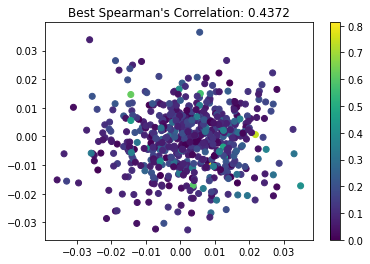

In [208]:
# Use VAE for feature selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert to tensor
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

input_dim = X_train.shape[1]
latent_dim = 50
num_trials = 20  # Number of times to train the model and select the best one
best_spearman = -float('inf')
best_model_state = None
best_latent_train = None
best_latent_test = None

for trial in range(num_trials):
    print(f"Training Trial {trial + 1}/{num_trials}")
    model = VAE(input_dim=input_dim, latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    train(model, train_loader, test_loader, optimizer, epochs=20, device=device)
    
    # Extract latent features from X_train
    latent_train, _ = model.encode(X_train_tensor)
    latent_test, _ = model.encode(X_test_tensor)
    latent_train = latent_train.detach().numpy()
    latent_test = latent_test.detach().numpy()
    print(latent_train.shape) 
    
    # Train a linear regression model on the encoded features
    vae_encoded_model = LinearRegression()
    vae_encoded_model.fit(latent_train, y_train)
    y_pred_vae = vae_encoded_model.predict(latent_test)
    
    # Calculate regression metrics
    mse_vae = mean_squared_error(y_test, y_pred_vae)
    r2_vae = r2_score(y_test, y_pred_vae)
    spearman_vae, p_value_vae = spearmanr(y_test, y_pred_vae)

    # Print the results
    print("--- VAE Encoded Features ---")
    print("Mean Squared Error (MSE):", mse_vae)
    print("R-squared (R²):", r2_vae)
    print("Spearman's Correlation (ρ):", spearman_vae)

    # Track the best model based on Spearman's correlation
    if spearman_vae > best_spearman:
        best_spearman = spearman_vae
        best_model_state = model.state_dict()  # Save the best model state
        best_latent_train = latent_train  # Save the best latent train features
        best_latent_test = latent_test    # Save the best latent test features

# After all trials, load the best model state
if best_model_state is not None:
    print(f"Best Spearman's Correlation (ρ) achieved: {best_spearman:.4f}")
    print("Loading the best model...")
    best_model = VAE(input_dim=input_dim, latent_dim=latent_dim).to(device)
    best_model.load_state_dict(best_model_state)
    
    # Plot only the best latent features
    plt.scatter(best_latent_train[:, 0], best_latent_train[:, 1], c=y_train['AAC'], cmap='viridis')
    plt.colorbar()
    plt.title(f"Best Spearman's Correlation: {best_spearman:.4f}")
    plt.show()

In [171]:
total_data = pd.concat([train_data, test_data])
total_data_tensor = torch.tensor(total_data.values, dtype=torch.float32)
encoded_features,_ = best_model.encode(total_data_tensor)
project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))
# Load the data
data_path = project_root / 'data' / 'encoded'
encoded_features = pd.DataFrame(encoded_features.detach().numpy(), columns=["encoded_feature_" + str(i) for i in range(encoded_features.shape[1])])
encoded_features.to_csv(data_path / 'vae_data.csv', index=False)

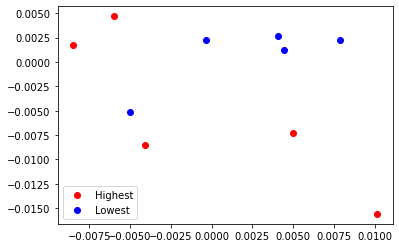

In [14]:
# PLot the 5 values with the highest and lowest values of AAC
# Sort the predictions
sorted_indices = np.argsort(y_train['AAC'].values)
# Get the 5 highest and lowest values
highest_indices = sorted_indices[-5:]
lowest_indices = sorted_indices[:5]
# Plot the values in latent space
plt.scatter(latent_train[highest_indices, 0], latent_train[highest_indices, 1], c='r', label='Highest')
plt.scatter(latent_train[lowest_indices, 0], latent_train[lowest_indices, 1], c='b', label='Lowest')
plt.legend()
plt.show()


In [104]:
from sklearn.neural_network import MLPRegressor
# Use a MLPRegressor
mlp_model = MLPRegressor(
    hidden_layer_sizes=(100, 50),  # Two hidden layers with 100 and 50 neurons
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    max_iter=1000,
    random_state=42
)
mlp_model.fit(latent_train, y_train['AAC'])
y_pred_mlp = mlp_model.predict(latent_test)
# Calculate regression metrics
mse_mlp = mean_squared_error(y_test['AAC'], y_pred_mlp)
r2_mlp = r2_score(y_test['AAC'], y_pred_mlp)
spearman_mlp, p_value_mlp = spearmanr(y_test['AAC'], y_pred_mlp)
# Print
print("--- MLP Regressor ---")
print("Mean Squared Error (MSE):", mse_mlp)
print("R-squared (R²):", r2_mlp)
print("Spearman's Correlation (ρ):", spearman_mlp)


--- MLP Regressor ---
Mean Squared Error (MSE): 0.00720598828151476
R-squared (R²): 0.03741497348510481
Spearman's Correlation (ρ): 0.2575641733759207


# Data Augmentation

In [16]:
# Add the project root directory to the Python path
project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))
# Load the data
data_path = project_root / 'data' / 'preprocessed'
train_augmented = pd.read_csv(data_path / 'train_augmented.csv')

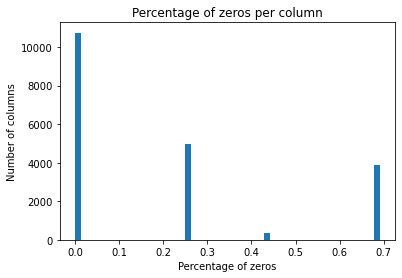

A3GALT2    0.690962
AADACL3    0.690962
AADACL4    0.690962
AARD       0.690962
AARS1      0.690962
             ...   
ZSCAN5B    0.690962
ZSCAN5C    0.690962
ZSWIM4     0.690962
ZSWIM9     0.690962
ZUP1       0.690962
Length: 3879, dtype: float64


In [17]:
# Plot percentage of samples == 0  per columns
percentage_zeros = (train_augmented == 0).mean()
percentage_zeros.plot(kind='hist', bins=50)
plt.xlabel('Percentage of zeros')
plt.ylabel('Number of columns')
plt.title('Percentage of zeros per column')
plt.show()
# Print all columns with more than 40% zeros
print(percentage_zeros[percentage_zeros > 0.6])

In [18]:
# Get all columns with more than 60% zeros
columns_to_drop = percentage_zeros[percentage_zeros > 0.6].index
# drop these columns
train_augmented = train_augmented.drop(columns=columns_to_drop)
# Split the data between extra data and fine tune data
fine_tune_data = train_augmented[:nb_cell_lines]
extra_data = train_augmented[nb_cell_lines:]

In [19]:
# Split the data
fine_tune_train, fine_tune_test, y_train, y_test = train_test_split(fine_tune_data, train_target, test_size=0.2, random_state=42)
extra_train, extra_test = train_test_split(extra_data, test_size=0.2, random_state=42)

In [20]:
# Define the autoencoder architecture
input_dim = extra_train.shape[1]
encoding_dim = 500

# Set the encoding dimension
input_layer = keras.layers.Input(shape=(input_dim,))
encoder = keras.layers.Dense(encoding_dim, activation="relu")(input_layer)
decoder = keras.layers.Dense(input_dim, activation="sigmoid")(encoder)
autoencoder = keras.Model(inputs=input_layer, outputs=decoder)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Summary of the autoencoder architecture
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16028)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 500)            │     8,014,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16028)          │     8,030,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,044,528 (61.21 MB)

 Trainable params: 16,044,528 (61.21 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
autoencoder.fit(extra_train, extra_train, epochs=10, batch_size=32, shuffle=True, validation_data=(extra_test, extra_test))

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - loss: 0.9108 - val_loss: 0.8095
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 0.7894 - val_loss: 0.7784
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 0.7586 - val_loss: 0.7513
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 0.7264 - val_loss: 0.7310
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.6980 - val_loss: 0.7181
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 0.6801 - val_loss: 0.7100
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.6605 - val_loss: 0.7030
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.6504 - val_loss: 0.6982
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.6383 - val_loss: 0.6951
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.6314 - val_loss: 0.6930


In [22]:
# Fine-tune the autoencoder
autoencoder.fit(fine_tune_train, fine_tune_train, epochs=10, batch_size=32, shuffle=True, validation_data=(fine_tune_test, fine_tune_test))

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - loss: 0.8093 - val_loss: 0.7641
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.7659 - val_loss: 0.7637
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.7577 - val_loss: 0.7619
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.7493 - val_loss: 0.7609
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.7206 - val_loss: 0.7599
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.7206 - val_loss: 0.7595
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.7255 - val_loss: 0.7593
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.7201 - val_loss: 0.7591
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.7168 - val_loss: 0.7588
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.7132 - val_loss: 0.7591


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Encoded Features Shape (Train): (593, 500)
Encoded Features Shape (Test): (149, 500)


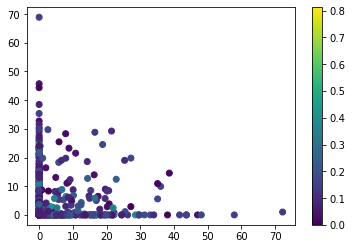

In [23]:
# Use encoder part of the autoencoder for feature selection
encoder = keras.Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)
encoded_features_train = encoder.predict(fine_tune_train)
encoded_features_test = encoder.predict(fine_tune_test)

# Display the shape of extracted features
print("Encoded Features Shape (Train):", encoded_features_train.shape)
print("Encoded Features Shape (Test):", encoded_features_test.shape)
# plot all encoded features
plt.scatter(encoded_features_train[:,0], encoded_features_train[:,1], c = y_train['AAC'], cmap='viridis')
plt.colorbar()
plt.show()

In [24]:
# --- Encoded Features ---
# Fit a linear regression model using the encoded features
encoded_model = LinearRegression()
encoded_model.fit(encoded_features_train, y_train)

# Make predictions on the test set
y_pred_encoded = encoded_model.predict(encoded_features_test)

# Calculate regression metrics
mse_encoded = mean_squared_error(y_test, y_pred_encoded)
r2_encoded = r2_score(y_test, y_pred_encoded)

# Calculate Spearman's rank correlation for encoded features
spearman_encoded, p_value_encoded = spearmanr(y_test, y_pred_encoded)

print("--- Encoded Features ---")
print("Mean Squared Error (MSE):", mse_encoded)
print("R-squared (R²):", r2_encoded)
print("Spearman's Correlation (ρ):", spearman_encoded)
print("P-value (Spearman):", p_value_encoded)

--- Encoded Features ---
Mean Squared Error (MSE): 0.04208095010284664
R-squared (R²): -4.621226525503842
Spearman's Correlation (ρ): 0.18302392801016779
P-value (Spearman): 0.025471003963444098


In [25]:
# Normalize the data
scaler = MinMaxScaler()
new_X_train_scaled = scaler.fit_transform(extra_train)

# Convert to tensor
new_X_train_tensor = torch.tensor(new_X_train_scaled, dtype=torch.float32)
new_dataset = TensorDataset(new_X_train_tensor)
new_train_loader = DataLoader(new_dataset, batch_size=32, shuffle=True)
new_X_test_tensor = torch.tensor(scaler.transform(extra_test), dtype=torch.float32)
new_test_dataset = TensorDataset(new_X_test_tensor)
new_test_loader = DataLoader(new_test_dataset, batch_size=32, shuffle=False)

X_train_scaled = scaler.fit_transform(fine_tune_train)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

X_test_tensor = torch.tensor(scaler.transform(fine_tune_test), dtype=torch.float32)
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
input_dim = extra_train.shape[1]
latent_dim = 50
augmented_model = VAE(input_dim=input_dim, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(augmented_model.parameters(), lr=1e-3)
train(augmented_model, new_train_loader,new_test_loader, optimizer, epochs=10, device=device)


Epoch 1/10, Train Loss: 1.6073, Val Loss: 0.2975
Epoch 2/10, Train Loss: 0.0940, Val Loss: 0.0343
Epoch 3/10, Train Loss: 0.0281, Val Loss: 0.0223
Epoch 4/10, Train Loss: 0.0206, Val Loss: 0.0181
Epoch 5/10, Train Loss: 0.0167, Val Loss: 0.0168
Epoch 6/10, Train Loss: 0.0143, Val Loss: 0.0116
Epoch 7/10, Train Loss: 0.0113, Val Loss: 0.0111
Epoch 8/10, Train Loss: 0.0105, Val Loss: 0.0098
Epoch 9/10, Train Loss: 0.0088, Val Loss: 0.0085
Epoch 10/10, Train Loss: 0.0076, Val Loss: 0.0074


In [26]:
# Fine-Tune the VAE
train(augmented_model, train_loader,test_loader, optimizer, epochs=20, device=device)

Epoch 1/20, Train Loss: 0.1036, Val Loss: 0.0767
Epoch 2/20, Train Loss: 0.0337, Val Loss: 0.0258
Epoch 3/20, Train Loss: 0.0123, Val Loss: 0.0153
Epoch 4/20, Train Loss: 0.0072, Val Loss: 0.0126
Epoch 5/20, Train Loss: 0.0053, Val Loss: 0.0110
Epoch 6/20, Train Loss: 0.0045, Val Loss: 0.0101
Epoch 7/20, Train Loss: 0.0038, Val Loss: 0.0097
Epoch 8/20, Train Loss: 0.0034, Val Loss: 0.0092
Epoch 9/20, Train Loss: 0.0031, Val Loss: 0.0089
Epoch 10/20, Train Loss: 0.0028, Val Loss: 0.0086
Epoch 11/20, Train Loss: 0.0026, Val Loss: 0.0086
Epoch 12/20, Train Loss: 0.0024, Val Loss: 0.0082
Epoch 13/20, Train Loss: 0.0023, Val Loss: 0.0081
Epoch 14/20, Train Loss: 0.0021, Val Loss: 0.0079
Epoch 15/20, Train Loss: 0.0020, Val Loss: 0.0078
Epoch 16/20, Train Loss: 0.0019, Val Loss: 0.0077
Epoch 17/20, Train Loss: 0.0018, Val Loss: 0.0075
Epoch 18/20, Train Loss: 0.0017, Val Loss: 0.0075
Epoch 19/20, Train Loss: 0.0016, Val Loss: 0.0074
Epoch 20/20, Train Loss: 0.0016, Val Loss: 0.0072


In [27]:
# Extract latent features from X_train
new_latent_train,_ = augmented_model.encode(X_train_tensor)
new_latent_test,_ = augmented_model.encode(X_test_tensor)
new_latent_train = new_latent_train.detach().numpy()
new_latent_test = new_latent_test.detach().numpy()
print(new_latent_train.shape) 

(593, 50)


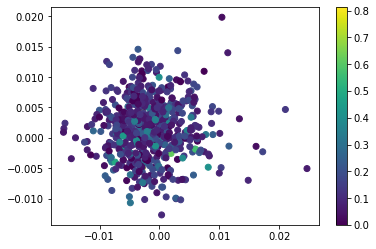

In [28]:
# plot all encoded features
plt.scatter(new_latent_train[:,0], new_latent_train[:,1], c = y_train['AAC'], cmap='viridis')
plt.colorbar()
plt.show()

In [29]:
vae_augmented_model = LinearRegression()
vae_augmented_model.fit(new_latent_train, y_train)
new_y_pred_vae = vae_augmented_model.predict(new_latent_test)
# Calculate regression metrics
mse_vae_augmented = mean_squared_error(y_test, new_y_pred_vae)
r2_vae_augmented = r2_score(y_test, new_y_pred_vae)
spearman_vae_augmented, p_value_vae_augmented = spearmanr(y_test, new_y_pred_vae)

# Print the results
print("--- VAE Encoded Features ---")
print("Mean Squared Error (MSE):", mse_vae_augmented)
print("R-squared (R²):", r2_vae_augmented)
print("Spearman's Correlation (ρ):", spearman_vae_augmented)

--- VAE Encoded Features ---
Mean Squared Error (MSE): 0.015442601678546079
R-squared (R²): -1.0628422591713584
Spearman's Correlation (ρ): 0.33455499234096137


# VAE 2

In [205]:
from pathlib import Path
import sys
import pandas as pd
# Load data from the encoded folder
# Add the project root directory to the Python path
project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))
# Load the data
data_path = project_root / 'data' / 'encoded'
encoded_data= pd.read_csv(data_path / 'ae_data.csv')

In [206]:
# Divide between train and test
nb_cell_lines = 742
encoded_train = encoded_data[:nb_cell_lines]
encoded_test = encoded_data[nb_cell_lines:]

In [209]:
# Print the shape of the data
print(encoded_train.shape)
# remove first column
#encoded_train = encoded_train.drop(columns=['Unnamed: 0'])

(742, 50)


In [195]:
import sys
sys.path.append("../utils")
from utils import load_data
from sklearn.model_selection import train_test_split

train, test, train_target = load_data(raw = False, categorical=False)
X_train, X_test, y_train, y_test = train_test_split(encoded_train, train_target, test_size=0.2, random_state=42)

In [196]:
# import lineargregresion
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
vae_augmented_model = LinearRegression()
vae_augmented_model.fit(X_train, y_train)
new_y_pred_vae = vae_augmented_model.predict(X_test)
# Calculate regression metrics
mse_vae_augmented = mean_squared_error(y_test, new_y_pred_vae)
r2_vae_augmented = r2_score(y_test, new_y_pred_vae)
spearman_vae_augmented, p_value_vae_augmented = spearmanr(y_test, new_y_pred_vae)

# Print the results
print("--- VAE Encoded Features ---")
print("Mean Squared Error (MSE):", mse_vae_augmented)
print("R-squared (R²):", r2_vae_augmented)
print("Spearman's Correlation (ρ):", spearman_vae_augmented)

--- VAE Encoded Features ---
Mean Squared Error (MSE): 0.007486050680925709
R-squared (R²): 3.884036851586892e-06
Spearman's Correlation (ρ): 0.2953240479994394


In [197]:
# Use MLP model
from mlp import MLP, train_margin_ranking
from torch import optim
import torch

# Model parameters
input_size = X_train.shape[1]
hidden_layers = [32, 16]  # Two hidden layers
margin = 1.0

# Convert DataFrames to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create model
model = MLP(input_size, hidden_layers)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

# Train the model
train_margin_ranking(model, optimizer, margin, X_train_tensor,y_train_tensor, X_test_tensor,y_test_tensor, epochs=1000)

/Users/Oskar/Desktop/Uni_Work/EPFL/Neuro-X/MA1/ML/projet_2/ml-project-2-lol-ml/src/notebooks/../utils/mlp.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/Users/Oskar/Desktop/Uni_Work/EPFL/Neuro-X/MA1/ML/projet_2/ml-project-2-lol-ml/src/notebooks/../utils/mlp.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
/Users/Oskar/Desktop/Uni_Work/EPFL/Neuro-X/MA1/ML/projet_2/ml-project-2-lol-ml/src/notebooks/../utils/mlp.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rat

Epoch [10/1000], Loss: 0.8218, Spearman: 0.4455 Validation Spearman: 0.3612773093392646
Epoch [20/1000], Loss: 0.7906, Spearman: 0.4778 Validation Spearman: 0.38544021897369285
Epoch [30/1000], Loss: 0.7590, Spearman: 0.5240 Validation Spearman: 0.4187379092491376
Epoch [40/1000], Loss: 0.7264, Spearman: 0.5723 Validation Spearman: 0.4396612004910211
Epoch [50/1000], Loss: 0.6940, Spearman: 0.6337 Validation Spearman: 0.43768405376768754
Epoch [60/1000], Loss: 0.6657, Spearman: 0.6876 Validation Spearman: 0.40713078825591587
Epoch [70/1000], Loss: 0.6329, Spearman: 0.7285 Validation Spearman: 0.42269764438403407
Epoch [80/1000], Loss: 0.6051, Spearman: 0.7663 Validation Spearman: 0.4034086735070347
Epoch [90/1000], Loss: 0.5945, Spearman: 0.7867 Validation Spearman: 0.40659387501728583
Epoch [100/1000], Loss: 0.5767, Spearman: 0.8078 Validation Spearman: 0.43009834037596173
Epoch [110/1000], Loss: 0.5666, Spearman: 0.8175 Validation Spearman: 0.4004901147200221
Epoch [120/1000], Loss: 

In [198]:
# Evaluate the model metrics
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
y_pred = model(X_test_tensor)
# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred.detach().numpy())
r2 = r2_score(y_test, y_pred.detach().numpy())
spearman, p_value = spearmanr(y_test, y_pred.detach().numpy())
# print the results
print("--- MLP Regressor ---")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)
print("Spearman's Correlation (ρ):", spearman)


--- MLP Regressor ---
Mean Squared Error (MSE): 0.7496089914585302
R-squared (R²): -99.13371694898657
Spearman's Correlation (ρ): 0.3932267647047432
